In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,roc_auc_score, confusion_matrix, matthews_corrcoef, make_scorer
from imblearn.over_sampling import *
import pickle

In [ ]:
df = pd.read_csv("/content/Latest_Merged_Coded.csv",  encoding='ISO-8859–1')
df.head()

,Unnamed: 0,index,command,category,coder,make_code,alarm,joke,misc,music,polite,search,volume,weather
0,0,522355,play hymns the sun by the beatles,music,G,4,0.0,0.0,0,1.0,0.0,0.0,0,0.0
1,1,314268,alexa what time is it,search,G,7,0.0,0.0,0,0.0,0.0,1.0,0,0.0
2,2,187019,alexa stop,music,G,4,0.0,0.0,0,1.0,0.0,0.0,0,0.0
3,3,141151,play,music,G,4,0.0,0.0,0,1.0,0.0,0.0,0,0.0
4,4,402967,can you say that joke again,joke,G,2,0.0,1.0,0,0.0,0.0,0.0,0,0.0


In [ ]:
df.at[1130,'category']='volume'
df.at[298,'category']='misc'
df.at[92,'category']='misc'
df.at[1816,'category']='misc'
df = df[df['category']!='random']
df['command']  = df['command'].astype('str')

<ipython-input-4-f0461d694083>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['command']  = df['command'].astype('str')


In [ ]:
X = df['command']
y = df['category']
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(X)

In [ ]:
adasyn = ADASYN(sampling_strategy='minority')
for _ in range(6):
  vectors, y = adasyn.fit_resample(vectors, y)

In [ ]:
y.value_counts()

search     487
weather    478
joke       476
music      474
polite     473
volume     473
alarm      472
misc       462
Name: category, dtype: int64

In [ ]:
train_vectors, test_vectors, y_train, y_test = train_test_split(vectors, y, test_size=0.2, random_state=40)

In [ ]:
parameters = {
    'penalty' : ['l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['lbfgs', 'liblinear'],
}
logreg = LogisticRegression(max_iter = 10000)
clf = GridSearchCV(logreg,                    
                   param_grid = parameters,   
                   scoring='roc_auc_ovr_weighted',        
                   cv=10)

In [ ]:
clf.fit(train_vectors,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc_ovr_weighted')

In [ ]:
print("Tuned Hyperparameters :", clf.best_params_)
print("roc_auc_ovr_weighted :",clf.best_score_)

Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
roc_auc_ovr_weighted : 0.9793634871162362


In [ ]:
best_logreg = LogisticRegression(class_weight = 'balanced',max_iter = 10000,C=1,penalty='l2',solver='lbfgs')
best_logreg.fit(train_vectors,y_train)
pred = best_logreg.predict(test_vectors)

In [31]:
my_tags = y.value_counts().index
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       alarm       0.99      0.89      0.94        92
        joke       0.99      0.86      0.92        85
        misc       0.86      0.70      0.77       100
       music       0.90      0.80      0.85        91
      polite       0.50      1.00      0.67        95
      search       0.87      0.82      0.84        88
      volume       0.97      0.79      0.87       106
     weather       0.88      0.69      0.77       102

    accuracy                           0.82       759
   macro avg       0.87      0.82      0.83       759
weighted avg       0.87      0.82      0.83       759



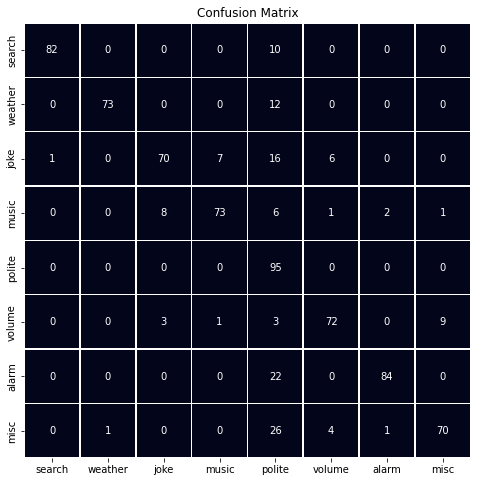

In [ ]:
x_axis_labels = y.value_counts().index
y_axis_labels = y.value_counts().index
cf_matrix = confusion_matrix(y_test, pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cf_matrix, annot=True, fmt='g', vmin=9999999, vmax=9999999, linewidths=.5,cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title="Confusion Matrix")
plt.show()

In [ ]:
filename = '/content/adasyn_other_categories_model.sav'
pickle.dump(best_logreg, open(filename, 'wb'))

In [ ]:
cnf_matrix = cf_matrix
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [ ]:
def mathew(fp, fn, tp, tn):
  num = (tp*tn)-(fp*fn)
  deno = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
  deno = np.sqrt(deno)

  num1 = tp+tn
  deno1 = tp+tn+fp+fn
  return num/deno, num1/deno1

In [ ]:
mc = []
acc = []
for fp,fn,tp,tn in zip(FP,FN,TP,TN):
  mcor, accu = mathew(fp, fn, tp, tn)
  mc.append(mcor)
  acc.append(accu)
mc,acc

([0.9305491694740868,
  0.9114466983749739,
  0.7485173705410237,
  0.8313818753541556,
  0.6545715052014461,
  0.8225266110508788,
  0.8572619893275792,
  0.7453499664814034],
 [0.9855072463768116,
  0.9828722002635046,
  0.9459815546772069,
  0.9657444005270093,
  0.8748353096179183,
  0.9644268774703557,
  0.9670619235836627,
  0.9446640316205533])

In [ ]:
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from scipy import interp

In [ ]:
def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    print(labels)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [ ]:
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=best_logreg.predict(test_vectors), 
    y_score=best_logreg.predict_proba(test_vectors))

print(report_with_auc)

['alarm' 'joke' 'misc' 'music' 'polite' 'search' 'volume' 'weather']
             precision    recall  f1-score  support   pred       AUC
alarm         0.987952  0.891304  0.937143     92.0   83.0  0.988756
joke          0.986486  0.858824  0.918239     85.0   74.0  0.987013
misc          0.864198  0.700000  0.773481    100.0   81.0  0.943498
music         0.901235  0.802198  0.848837     91.0   81.0  0.973202
polite        0.500000  1.000000  0.666667     95.0  190.0  0.972892
search        0.867470  0.818182  0.842105     88.0   83.0  0.978882
volume        0.965517  0.792453  0.870466    106.0   87.0  0.980684
weather       0.875000  0.686275  0.769231    102.0   80.0  0.966015
avg / total   0.867730  0.815547  0.826126    759.0  759.0  0.977710


In [ ]:
scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
cv_logreg = LogisticRegression(class_weight = 'balanced',max_iter = 10000,C=1,penalty='l2',solver='lbfgs')
scores = cross_validate(cv_logreg, train_vectors, y_train, cv=10, scoring=scoring)

scores

{'fit_time': array([0.23814583, 0.23223686, 0.2346909 , 0.21950126, 0.22419262,
        0.21332502, 0.22402716, 0.31011057, 0.21442938, 0.2156074 ]),
 'score_time': array([0.0072372 , 0.00773478, 0.00684214, 0.00718331, 0.00712729,
        0.00699091, 0.00769711, 0.00689459, 0.00705814, 0.00720692]),
 'test_accuracy': array([0.81907895, 0.85526316, 0.81578947, 0.82236842, 0.82565789,
        0.86842105, 0.82838284, 0.88118812, 0.84488449, 0.81188119]),
 'test_precision_macro': array([0.87039766, 0.89517225, 0.85739361, 0.87291852, 0.86364087,
        0.90733316, 0.87474806, 0.90678186, 0.8695477 , 0.86606923]),
 'test_recall_macro': array([0.81809211, 0.85489819, 0.81516691, 0.81980907, 0.82229692,
        0.86807394, 0.82729256, 0.88061885, 0.84435448, 0.81036044]),
 'test_f1_macro': array([0.82836162, 0.86259369, 0.82195311, 0.8295467 , 0.82720861,
        0.87685099, 0.83660031, 0.88563432, 0.84788203, 0.82081663])}

In [ ]:
print("test acc: ",scores['test_accuracy'].mean())
print("test_precision_macro: ",scores['test_precision_macro'].mean())
print("test_recall_macro: ",scores['test_recall_macro'].mean())
print("test_f1_macro: ",scores['test_f1_macro'].mean())
myscore = make_scorer(roc_auc_score, multi_class='ovr',needs_proba=True)
suc = cross_validate(cv_logreg, train_vectors, y_train, cv=10, scoring = myscore)
print("ROC AUC score: ",suc['test_score'].mean())

test acc:  0.8372915581031789
test_precision_macro:  0.8784002919294183
test_recall_macro:  0.8360963468529258
test_f1_macro:  0.8437448020815219
ROC AUC score:  0.9791173547242631
